In [6]:
colorList=[]
open("juliaColors.txt","r") do f
    for line in eachline(f)
        push!(colorList,line)
    end
end

In [9]:
for color in colorList
    println(color)
end

aliceblue
antiquewhite
antiquewhite1
antiquewhite2
antiquewhite3
antiquewhite4
aqua
aquamarine
aquamarine1
aquamarine2
aquamarine3
aquamarine4
azure
azure1
azure2
azure3
azure4
beige
bisque
bisque1
bisque2
bisque3
bisque4
black
blanchedalmond
blue
blue1
blue2
blue3
blue4
blueviolet
brown
brown1
brown2
brown3
brown4
burlywood
burlywood1
burlywood2
burlywood3
burlywood4
cadetblue
cadetblue1
cadetblue2
cadetblue3
cadetblue4
chartreuse
chartreuse1
chartreuse2
chartreuse3
chartreuse4
chocolate
chocolate1
chocolate2
chocolate3
chocolate4
coral
coral1
coral2
coral3
coral4
cornflowerblue
cornsilk
cornsilk1
cornsilk2
cornsilk3
cornsilk4
crimson
cyan
cyan1
cyan2
cyan3
cyan4
darkblue
darkcyan
darkgoldenrod
darkgoldenrod1
darkgoldenrod2
darkgoldenrod3
darkgoldenrod4
darkgray
darkgreen
darkgrey
darkkhaki
darkmagenta
darkolivegreen
darkolivegreen1
darkolivegreen2
darkolivegreen3
darkolivegreen4
darkorange
darkorange1
darkorange2
darkorange3
darkorange4
darkorchid
darkorchid1
darkorchid2
darkorchid3


In [ ]:
r,rad,m=initCondGen(9)

In [22]:
dR(r,m)

UndefVarError: UndefVarError: r not defined

In [47]:
test=Array((Float64,Float64),10)

MethodError: MethodError: no method matching Array(::Tuple{DataType,DataType}, ::Int64)
Closest candidates are:
  Array(!Matched::LinearAlgebra.UniformScaling, ::Integer, !Matched::Integer) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/uniformscaling.jl:407

In [60]:
x=[1,1,1,0]
all(x.==1)

false

In [6]:
using Plots, Random, Printf

function initCondGen(nBodies) #get random initial conditions for mass/radius, position, and velocity
    m=rand(1:1500,nBodies)./10 #n random masses between 0.1 and 150 solar masses
    rad=m.^0.8 #3 radii based on masses in solar units
    m=m.*2e30 #convert to SI kg
    rad=rad.*7e8 #convert to SI m
    posList=[]
    function checkPos(randPos,n,posList,rad)
        for i=2:(n-1)
            dist=sqrt((posList[i][1]-randPos[1])^2+(posList[i][2]-randPos[2])^2)
            if (dist*1.5e11)<(rad[n]+rad[i])
                return false
            end
        end
        return true
    end
    function genPos(nBodies,posList,rad)
        push!(posList,rand(-35:35,2)) #random initial x,y coords for 1st body, 70 AU box width
        for n=2:nBodies
            acceptPos=false
            while acceptPos==false
                randPos=rand(-35:35,2)
                acceptPos=checkPos(randPos,n,posList,rad)
                if acceptPos==true
                    push!(posList,randPos)
                end
            end
        end
        return posList
    end
    pos=genPos(nBodies,posList,rad).*1.5e11 #convert to SI, m
    v=[]
    for n=1:nBodies
        push!(v,rand(-7e3:7e3,2)) #random x & y velocity between -7:7 km/s
    end
    r=[]
    for n=1:nBodies
        push!(r,pos[n])
    end
    for n=1:nBodies
        push!(r,v[n])
    end
  #  open("initCond.txt","w") do f #save initial conditions to file in folder where script is run
   #     write(f,"m1=$(@sprintf("%.1f",(m[1]/2e30))) m2=$(@sprintf("%.1f",(m[2]/2e30))) m3=$(@sprintf("%.1f",(m[3]/2e30))) (solar masses)\nv1x=$(v[1]/1e3) v1y=$(v[2]/1e3) v2x=$(v[3]/1e3) v2y=$(v[4]/1e3) v3x=$(v[5]/1e3) v3y=$(v[6]/1e3) (km/s)\nx1=$(pos1[1]) y1=$(pos1[2]) x2=$(pos2[1]) y2=$(pos2[2]) x3=$(pos3[1]) y3=$(pos3[2]) (AU from center)")
   # end
    return [r, rad, m]
end

function dR(r,m,nBodies) #function we will use RK4 on to approximate solution
    G=6.67408313131313e-11# Nm^2/kg^2
    C=m.*G #Nm^2/kg
    function getDist(pos1,pos2)
        x1,y1=pos1[1],pos1[2]
        x2,y2=pos2[1],pos2[2]
        dist=sqrt((x1-x2)^2+(y1-y2)^2)
        return dist
    end
    function getDv(C,n,r,nBodies)
        pos=r[1:nBodies]
        dVx=0
        dVy=0
        for i=1:nBodies
            if i!=n
                dist=getDist(pos[n],pos[i])
               # println("dist at i = $i : $(dist/1.5e11)")
                c=C[i]
                dVx-=c*(pos[n][1]-pos[i][1])/dist^3
                dVy-=c*(pos[n][2]-pos[i][2])/dist^3
            end
        end
       # println("dVx for n = $n: $(dVx)")
        return [dVx,dVy]
    end

    rUpdate=copy(r) #otherwise we modify r in place
    dr=r[(nBodies+1):nBodies*2] #old v*dt = dr
    dv=[]
    for n=1:nBodies
        dVn=getDv(C,n,r,nBodies)
        push!(dv,dVn)
    end
    rUpdate[1:nBodies]=dr[1:nBodies] #update positions
    rUpdate[(nBodies+1):nBodies*2]=dv[1:nBodies] #update velocities
    return rUpdate
end

dR (generic function with 1 method)

In [7]:
function checkSep(xList,yList,nBodies,i,m,r,rad,names,colors,maxSep)
                sepList=[]
                for n1=1:nBodies
                    for n2=(n1+1):nBodies
                        x1,y1=xList[n1][i],yList[n1][i]
                        x2,y2=xList[n2][i],yList[n2][i]
                        sep=sqrt((x1-x2)^2+(y1-y2)^2)
                        push!(sepList,sep)
                        minSep=rad[n1]+rad[n2]
                        if sep<minSep
                            sharedX=(x1+x2)/2
                            sharedY=(y1+y2)/2
                            p1x,p1y=m[n1]*r[n1+nBodies][1],m[n1]*r[n1+nBodies][2] #get momenta
                            p2x,p2y=m[n2]*r[n2+nBodies][1],m[n2]*r[n2+nBodies][2]
                            pTotx,pToty=p1x+p2x,p1y+p2y
                            newMass=m[n1]+m[n2]
                            sharedVfX=pTotx/(newMass) #perfectly inelastic collision
                            sharedVfY=pToty/(newMass)
                            r[n1][1]=sharedX #replace coordinates of one of the old bodies with new shared coords
                            r[n1][2]=sharedY
                            r[n1+nBodies][1]=sharedVfX #ditto for velocity
                            r[n1+nBodies][2]=sharedVfY
                            r[n2]=true #mark for removal
                            r[n2+nBodies]=true
                            filter!(x->x!=true,r) #filter and remove n2 entries
                            split1,split2=split(names[n1]),split(names[n2])
                            if split1[end]=="hole"
                                names[n1]=names[n1][1:(end-11)]
                            elseif split2[end]=="hole"
                                names[n2]=names[n2][1:(end-11)]
                            end
                            newName=string(names[n1]," & ",names[n2]," black hole")
                            
                            names[n1]=newName
                            deleteat!(names,n2)
                            deleteat!(colors,n2)
                            m[n1]=newMass #update mass to reflect merger
                            deleteat!(m,n2) #delete the other
                            newRad=2*(6.6743015e-11)*newMass/(9e16) #schwarzschild radius
                            rad[n1]=newRad #update radii list to reflect merger
                            deleteat!(rad,n2)
                            return true,r,nBodies-1,names,colors,m,rad
                        end
                    end
                end
                if minimum(sepList)>maxSep*1.5e11
                    return true,r,nBodies,names,colors,m,rad #stop if everybody flew away
                end
                return false,r,nBodies,names,colors,m,rad
            end
function genNBodyStep(nBodies, physInfo, names, colors, stopCond=[10,100],dt=0.033) #default stop conditions of 10 yrs and 100 AU sep
    tStop=stopCond[1]*365*24*3600 #convert to SI s
    sepStop=stopCond[2]*1.5e11 #convert to SI m
    stop=false
    numSteps=Int(ceil(stopCond[1]/dt))
    t=range(0,stop=tStop,length=(numSteps+1)) #+1 because I don't want 0 to count
    stepSize=dt*365*24*3600 #convert to SI s
    xList=[]
    yList=[]
    for n=1:nBodies
        push!(xList,zeros(length(t)))
        push!(yList,zeros(length(t)))
    end
    r,rad,m=copy(physInfo[1]),copy(physInfo[2]),copy(physInfo[3]) #need copy because otherwise they're just pointers
    colors=copy(colors) #same reasoning as above
    names=copy(names)
    i=1
    currentT=t[i]
    #implement RK4 to model solutions to differential equations
    while stop==false
        if currentT>=tStop #in case of rounding error or something
            stop=true
        elseif i>(numSteps+1) #inf loop failsafe
            stop=true
            println("error: shouldn't have gotten here")
        else
            for n=1:nBodies
                xList[n][i]=r[n][1]
                yList[n][i]=r[n][2]
            end
            k1=stepSize.*dR(r,m,nBodies)
            k2=stepSize.*dR(r.+0.5.*k1,m,nBodies)
            k3=stepSize.*dR(r.+0.5.*k2,m,nBodies)
            k4=stepSize.*dR(r.+k3,m,nBodies)
            r.+=(k1.+2.0.*k2.+2.0.*k3.+k4)./6
            #check separation after each dt step
            stop,r,nBodies,names,colors,m,rad=checkSep(xList,yList,nBodies,i,m,r,rad,names,colors,sepStop)
            if stop==true
                t=range(0,stop=currentT,length=i) #t should match pos vectors
                for n=1:(nBodies+1)
                    xList[n]=xList[n][1:i]
                    yList[n]=yList[n][1:i]
                end
            else
                i+=1
                currentT=t[i]
            end
        end
    end
    return ([xList, yList, t], [r, rad, m], nBodies, names, colors, currentT/365/24/3600)
end

genNBodyStep (generic function with 3 methods)

In [86]:
nBodies=7
names=["$i" for i=1:nBodies]
randInd=rand(1:length(colorList),nBodies)
colors=[colorList[i] for i in randInd]
physInfo=initCondGen(nBodies)
plotInfo,physInfo,nBodies,names,colors,t=genNBodyStep(nBodies,physInfo,names,colors,[10,100],0.033)
t

10.0

In [8]:
#nBodies=7
#names=["$i" for i=1:nBodies]
#randInd=rand(1:length(colorList),nBodies)
#colors=[colorList[i] for i in randInd]

function genNBody(nBodies, names, colors; stopCond=[10,100],dt=0.033)
    physInfo=initCondGen(nBodies)
    globalT=0
    stopT=stopCond[1] #yrs
    numTrials=0
    plotList=[]
    tOffsets=[0.0]
    namesList=[names]
    colorsList=[colors]
    physInfoList=[]
    while globalT<stopT && nBodies>1
        rad,m=physInfo[2],physInfo[3]
        plotInfo,newPhysInfo,nBodies,names,colors,t=genNBodyStep(nBodies,physInfo,names,colors,[stopT-globalT,stopCond[2]],dt)
        globalT+=t
        numTrials+=1
        println("number of output files at this step: $(ceil(t/dt))")
        push!(tOffsets,globalT)
        push!(plotList,plotInfo)
        push!(namesList,names)
        push!(colorsList,colors)
        push!(physInfoList,[rad,m]) #we don't need to save r because that happens in x & y
        physInfo=newPhysInfo
    end
    deleteat!(tOffsets,length(tOffsets))#we don't want the last thing here 
    println("made it $globalT years with $nBodies surviving")
    return numTrials,plotList,tOffsets,physInfoList,namesList,colorsList
end

#nTrials,plotList,tOffsets,physInfoList,namesList,colorsList=genNBody(nBodies,names,colors,dt=0.033/64)
#tOffsets

genNBody (generic function with 1 method)

In [21]:
physInfoList[end][1]

4-element Array{Any,1}:
      3.714090265253893e10
 403424.44622222224
 522968.60197777784
 815154.6898666667

In [30]:
function getInterestingNBody(nBodies,names,colors; minTime=0,stopCond=[10,100],dt=0.033,iMax=10) #in years, defaults to 0
    #sometimes random conditions result in a really short animation where things
    #just crash into each other/fly away, so this function throws away those
    yearSec=365*24*3600
    interesting=false
    i=1
    while interesting==false
        nTrials,plotList,tOffsets,physInfoList,namesList,colorsList=genNBody(nBodies,names,colors,stopCond=stopCond,dt=dt)
        stopT=tOffsets[end]+plotList[end][3][end]/yearSec
        if (stopT)>=minTime #only return if simulation runs for longer than minTime
            println("total time: ",stopT) #tell me how many years we are simulating
            open("cron_log.txt","a") do f #for cron logging, a flag = append
                write(f,"$(stopT)\n")
            end
            return nTrials,plotList,tOffsets,physInfoList,namesList,colorsList
            interesting=true
        elseif i>iMax #computationally expensive so don't want to go forever
            interesting=true #render it anyways I guess because sometimes it's fun?
            println("did not find interesting solution in number of tries allotted, running anyways")
            println("total time: ",stopT) #how many years simulation runs for
            open("cron_log.txt","a") do f #for cron logging
                write(f,"$(stopT)\n")
            end
            return nTrials,plotList,tOffsets,physInfoList,namesList,colorsList
        end
        i+=1
    end
end
#nBodies=7
#names=["$i" for i=1:nBodies]
#randInd=rand(1:length(colorList),nBodies)
#colors=[colorList[i] for i in randInd]
#nTrials,plotList,tOffsets,physInfoList,namesList,colorsList=getInterestingNBody(nBodies,names,colors,dt=0.033/64)
#colorsList[1]

getInterestingNBody (generic function with 1 method)

In [10]:
function getLims(xList,yList,padding,maxFrame) #determines plot limits at each frame, padding in units of pos
    xMin=minimum(xList)
    xMax=maximum(xList)
    dx=xMax-xMin
    yMin=minimum(yList)
    yMax=maximum(yList)
    dy=yMax-yMin
    
    if dx>dy && dx<maxFrame
        #use x for square
        xlims=[xMin-padding,xMax+padding]
        ylims=[yMin-padding,yMin+dx+padding]
    elseif dy>dx &&dy<maxFrame
        #use y for square
        xlims=[xMin-padding,xMin+dy+padding]
        ylims=[yMin-padding,yMax+padding]
    else
        sep=[]
        ind=[]
        for i=1:length(xList)
            for j=(i+1):length(xList)
                dist=sqrt((xList[i]-xList[j])^2 + (yList[i]-yList[j])^2)
                push!(sep,dist)
                push!(ind,[i,j])
            end
        end
        closestInd=argmin(sep)
        i,j=ind[closestInd]
        centerX=(xList[i]+xList[j])/2 #center on the closest remaining pair
        centerY=(yList[i]+yList[j])/2 
        xlims=[centerX-maxFrame/2-padding,centerX+maxFrame/2+padding]#keep padding to be consistent w/above
        ylims=[centerY-maxFrame/2-padding,centerY+maxFrame/2+padding]#even though it makes maxFrame not really max frame
    end
    return xlims,ylims
end

getLims (generic function with 1 method)

In [115]:
xTest

7-element Array{Float64,1}:
  42.6174809045198
  20.766975985513042
 -20.56725149146227
 -20.71533208648798
 -25.841467748264737
   4.209221416031496
   9.305627086359042

In [116]:
xTest=zeros(length(plotInfo[1]))
yTest=zeros(length(plotInfo[2]))
for i=1:length(xTest)
    xTest[i]=plotInfo[1][i][end]/1.5e11
    yTest[i]=plotInfo[2][i][end]/1.5e11
end
xlims,ylims=getLims(xTest,yTest,10,100)

([-35.84146774826473, 52.6174809045198], [-28.879758631851416, 59.579190020933126])

In [55]:
function makeCircleVals(r,center=[0,0])
    xOffset=center[1]
    yOffset=center[2]
    xVals=[r*cos(i)+xOffset for i=0:(pi/64):(2*pi)]
    yVals=[r*sin(i)+yOffset for i=0:(pi/64):(2*pi)]
    return xVals,yVals
end
labels=["Joe","Liza","Amy","Richard","Ted","Dave","Morgan"] #joe is grandma
names=copy(labels)
nBodies=7
nBodies0=copy(nBodies)
randInd=rand(1:length(colorList),nBodies)
colors=[colorList[i] for i in randInd]
nTrials,plotList,tOffsets,physInfoList,namesList,colorsList=getInterestingNBody(nBodies,names,colors,dt=0.0001,stopCond=[50,100],minTime=40)
nBodiesList=[nBodies0-i for i=0:(nTrials-1)]
#adding fake stars
numStars=2500
starsX=zeros(numStars)
starsY=zeros(numStars)
function getMax(plotList,ind)
    MAX=0
    for i=1:length(plotList)
        for j=1:length(plotList[end][ind])
            localMax=maximum(plotList[i][ind][j])
            if localMax>MAX
                MAX=localMax
            end
        end
    end
    return MAX/1.5e11
end
function getMin(plotList,ind)
    MIN=0
    for i=1:length(plotList)
        for j=1:length(plotList[end][ind])
            localMin=minimum(plotList[i][ind][j])
            if localMin<MIN
                MIN=localMin
            end
        end
    end
    return MIN/1.5e11
end
minMax=zeros(4)
minMax[1],minMax[2]=getMax(plotList,1),getMax(plotList,2)
minMax[3],minMax[4]=getMin(plotList,1),getMin(plotList,2)
boxMin=floor(minimum(minMax))
boxMax=ceil(maximum(minMax))
for i=1:numStars
    num=rand(boxMin:boxMax,2) #box size is 70 AU but we need some extra padding for movement
    starsX[i]=num[1]
    starsY[i]=num[2]
end

#this new way runs significantly faster (~2x improvement over @anim)
#Downside is it spams folder with png images of every frame and must manually compile with ffmpeg
#Comment out and use older way (after this below) if performance/specific formatting is not an issue
function plotSection(sectionNum,backData,oldI,oldColors,offsets,dt,nBodies,plotInfo,physInfo,labels,colors,maxFrame)
    colorSymbols=[Symbol(color) for color in colors]
    oldColorSymbols=[Symbol(color) for color in oldColors]
    skipRate=Int(floor(1/dt/30)) #30 fps
    rad=physInfo[1]
    m=physInfo[2]
    xData=plotInfo[1]
    yData=plotInfo[2]
    t=plotInfo[3]
    tOffset=offsets[1]
    plotNum=offsets[2]
    I=0
    
    for i=1:skipRate:length(t) #this makes animation scale ~1 sec/year with other conditions
        GR.inline("png") #added to eneable cron/jobber compatibility, also this makes frames generate WAY faster? Prior to adding this when run from cron/jobber frames would stop generating at 408 for some reason.
        gr(legendfontcolor = plot_color(:white)) #legendfontcolor=:white plot arg broken right now (at least in this backend)
        if sectionNum>1 
           # iOffset=length(backData[1][1])
            p=plot(backData[1][1]./1.5e11,backData[1][2]./1.5e11,label="",linecolor=oldColorSymbols[1],linealpha=max.((1:Int(floor(skipRate)):oldI) .+ 10000 .- (oldI+i),2500)/10000)
            for n=2:(nBodies+1) #old list has +1 bodies
                p=plot!(backData[n][1]./1.5e11,backData[n][2]./1.5e11,label="",linecolor=oldColorSymbols[n],linealpha=max.((1:Int(floor(skipRate)):oldI) .+ 10000 .- (oldI+i),2500)/10000)
            end
        else
            p=plot()
        end
        print("$(@sprintf("%.2f",i/length(t)*100)) % complete\r") #output percent tracker
        x=[]
        y=[]
        iOffset=i
        for n=1:nBodies
            push!(x,xData[n][i]/1.5e11)
            push!(y,yData[n][i]/1.5e11)
        end
        limx,limy=getLims(x,y,10,maxFrame) #10 AU padding
        
        p=plot!(xData[1][1:Int(floor(skipRate/10)):i]./1.5e11,yData[1][1:Int(floor(skipRate/10)):i]./1.5e11,label="",linecolor=colorSymbols[1],linealpha=max.((1:Int(floor(skipRate/10)):i) .+ 10000 .- i,2500)/10000)
        for n=2:nBodies
            p=plot!(xData[n][1:Int(floor(skipRate/10)):i]./1.5e11,yData[n][1:Int(floor(skipRate/10)):i]./1.5e11,label="",linecolor=colorSymbols[n],linealpha=max.((1:Int(floor(skipRate/10)):i) .+ 10000 .- i,2500)/10000)
        end
        p=scatter!(starsX,starsY,markercolor=:white,markersize=:1,label="") #fake background stars
        for n=1:nBodies
            circleX,circleY=makeCircleVals(rad[n],[xData[n][i],yData[n][i]])
            if split(labels[n])[end]=="hole"
                fillColor=:black
            else
                fillColor=colorSymbols[n]
            end
            p=plot!(circleX./1.5e11,circleY./1.5e11,label=labels[n],color=colorSymbols[n],fill=true,fillcolor=fillColor)
        end

        p=plot!(background_color=:black,background_color_legend=:transparent,foreground_color_legend=:transparent,
            background_color_outside=:white,aspect_ratio=:equal,legendtitlefontcolor=:white) #formatting for plot frame
        currentT=t[i]/365/24/3600+tOffset
        p=plot!(xlabel="x: AU",ylabel="y: AU",title="Random Long Body Problem\nt: $(@sprintf("%0.2f",currentT)) yrs after start",
            legend=:best,xaxis=("x: AU",(limx[1],limx[2]),font(9,"Courier")),yaxis=("y: AU",(limy[1],limy[2]),font(9,"Courier")),
            grid=false,titlefont=font(14,"Courier"),size=(720,721),legendfontsize=8,legendtitle="Contestants",legendtitlefontsize=8) #add in axes/title/legend with formatting
        plotNum+=1
        png(p,@sprintf("tmpPlots/frame_%06d.png",plotNum))
        closeall() #close plots
        I+=skipRate
    end
    if I>10000 
        I=10000
    end
    backData=[]
    for n=1:nBodies
        xBack=xData[n][1:Int(floor(skipRate/10)):end]
        yBack=yData[n][1:Int(floor(skipRate/10)):end]
        push!(backData,[xBack,yBack])
    end
    return plotNum,backData,I
end

#num1=plotSection([0,0],0.001,nBodiesList[1],plotList[1],physInfoList[1],namesList[1],colorsList[1],1000)
plotAll(nBodiesList,plotList,physInfoList,namesList,colorsList,100,tOffsets,0.0001)

number of output files at this step: 12050.0
number of output files at this step: 26842.0
number of output files at this step: 461108.0
number of output files at this step: 1.0
made it 50.0 years with 5 surviving
total time: 50.0
plotting step 1 of 4
plotting step 2 of 4
plotting step 3 of 4
plotting step 4 of 4


In [36]:
function plotAll(nBodiesList,plotList,physInfoList,namesList,colorsList,maxFrame,tOffsets,dt)
    frameOffset=0 #start at one because frame numbers start at 1
    backData=[]
    oldI=0
    for i=1:length(nBodiesList)
        println("plotting step $i of $(length(nBodiesList))")
        currentNBodies=nBodiesList[i]
        currentPlotData=plotList[i]
        currentPhysInfo=physInfoList[i]
        currentNames=namesList[i]
        currentColors=colorsList[i]
        if i>1
            oldColors=colorsList[i-1]
        else
            oldColors=[]
        end
        currentTOffset=tOffsets[i]
        currentFrame,backData,oldI=plotSection(i,backData,oldI,oldColors,[currentTOffset,frameOffset],dt,currentNBodies,currentPlotData,currentPhysInfo,currentNames,currentColors,maxFrame)
        frameOffset+=currentFrame
    end
end
        

plotAll (generic function with 1 method)

# new things to do

fix backData issue so lines are permanent

maybe change fill of black holes to be black??

In [126]:
function getLims(xList,yList,padding,maxFrame) #determines plot limits at each frame, padding in units of pos
    xMin=minimum(x)
    xMax=maximum(x)
    dx=xMax-xMin
    yMin=minimum(y)
    yMax=maximum(y)
    dy=yMax-yMin
    if dx>dy && dx<maxFrame
        #use x for square
        xlims=[xMin-padding,xMax+padding]
        ylims=[yMin-padding,yMin+dx+padding]
    elseif dy>dx && dy<maxFrame
        #use y for square
        xlims=[xMin-padding,xMin+dy+padding]
        ylims=[yMin-padding,yMax+padding]
    else
        xlims=[maxFrame]
    end
    return xlims,ylims
end

function makeCircleVals(r,center=[0,0])
    xOffset=center[1]
    yOffset=center[2]
    xVals=[r*cos(i)+xOffset for i=0:(pi/64):(2*pi)]
    yVals=[r*sin(i)+yOffset for i=0:(pi/64):(2*pi)]
    return xVals,yVals
end
labels=["Joe","Liza","Amy","Richard","Ted","Dave","Morgan"] #joe is grandma
nBodies=7
xData,yData,t,m,rad=getInterestingNBody(nBodies,15)
#adding fake stars
numStars=2500
starsX=zeros(numStars)
starsY=zeros(numStars)
for i=1:numStars
    num=rand(-200:200,2) #box size is 70 AU but we need some extra padding for movement
    starsX[i]=num[1]
    starsY[i]=num[2]
end

#this new way runs significantly faster (~2x improvement over @anim)
#Downside is it spams folder with png images of every frame and must manually compile with ffmpeg
#Comment out and use older way (after this below) if performance/specific formatting is not an issue

plotLoadPath="tmpPlots/"
nBodyAnim=Animation(plotLoadPath,String[])

for i=1:33:length(t) #this makes animation scale ~1 sec/year with other conditions
    GR.inline("png") #added to eneable cron/jobber compatibility, also this makes frames generate WAY faster? Prior to adding this when run from cron/jobber frames would stop generating at 408 for some reason.
    gr(legendfontcolor = plot_color(:white)) #legendfontcolor=:white plot arg broken right now (at least in this backend)
    print("$(@sprintf("%.2f",i/length(t)*100)) % complete\r") #output percent tracker
    x=[]
    y=[]
    for n=1:nBodies
        push!(x,xData[n][i]/1.5e11)
        push!(y,yData[n][i]/1.5e11)
    end
    limx,limy=getLims(x,y,10) #10 AU padding
    p=plot(xData[1][1:i]./1.5e11,yData[1][1:i]./1.5e11,label="",linecolor=:auto,linealpha=max.((1:i) .+ 10000 .- i,2500)/10000)
    for n=2:nBodies
        p=plot!(xData[n][1:i]./1.5e11,yData[n][1:i]./1.5e11,label="",linecolor=:auto,linealpha=max.((1:i) .+ 10000 .- i,2500)/10000)
    end
    p=scatter!(starsX,starsY,markercolor=:white,markersize=:1,label="") #fake background stars
    for n=1:nBodies
        circleX,circleY=makeCircleVals(rad[n],[xData[n][i],yData[n][i]])
        p=plot!(circleX./1.5e11,circleY./1.5e11,label=labels[n],color=:auto,fill=true)
    end

    p=plot!(background_color=:black,background_color_legend=:transparent,foreground_color_legend=:transparent,
        background_color_outside=:white,aspect_ratio=:equal,legendtitlefontcolor=:white) #formatting for plot frame
    p=plot!(xlabel="x: AU",ylabel="y: AU",title="Random Long Body Problem\nt: $(@sprintf("%0.2f",t[i]/365/24/3600)) yrs after start",
        legend=:best,xaxis=("x: AU",(limx[1],limx[2]),font(9,"Courier")),yaxis=("y: AU",(limy[1],limy[2]),font(9,"Courier")),
        grid=false,titlefont=font(14,"Courier"),size=(720,721),legendfontsize=8,legendtitle="Contestants",legendtitlefontsize=8) #add in axes/title/legend with formatting
    frame(nBodyAnim,p) #generate the frame
    closeall() #close plots
end

50.0


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


InterruptException: InterruptException:

In [128]:
maximum(t)/3600/24

4.38

In [130]:
xList[1]

13-element Array{Float64,1}:
 -1.95e12
  1.1130581781524726e57
  3.710899824040809e56
  6.362344377105025e65
  2.121184956268463e65
 -3.2862956682576013e48
 -3.131736945266209e51
 -1.0287201891841955e51
 -2.4375778482559063e52
 -8.05600189119602e51
 -2.7003424844854266e56
 -9.002854165259237e55
 -1.1123899149081995e69

In [47]:
x=[1,2,3,4,5,6]

6-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6

In [164]:
deleteat!(x,1,6)

MethodError: MethodError: no method matching deleteat!(::Array{Int64,1}, ::Int64, ::Int64)
Closest candidates are:
  deleteat!(::Array{T,1} where T, ::Integer) at array.jl:1237
  deleteat!(::Array{T,1} where T, ::Any) at array.jl:1274
  deleteat!(::Array{T,1} where T, !Matched::UnitRange{#s69} where #s69<:Integer) at array.jl:1240
  ...

In [129]:
a=[1,2,3]
b=a
b[1]=0

0

In [130]:
a

3-element Array{Int64,1}:
 0
 2
 3

In [159]:
a= "hello"
b = "world"
c = join(a,b)

"hworldeworldlworldlworldo"

In [22]:
colorList=[]
open("juliaColors.txt","r") do f
    for line in eachline(f)
        push!(colorList,split(line)[1][2:end-1])
    end
end

In [19]:
colorList[1]

"aliceblue"

In [20]:
colorSymbols=[]
for color in colorList
    push!(colorSymbols,Symbol(color))
end

In [23]:
open("juliaColors.txt","w") do f
    for color in colorList
        write(f,"$color\n")
    end
end

In [276]:
using Printf

In [18]:
for i=1:10
    println("@sprintf("test_%03d",i)@sprintf("test_%03d",i)sdfjl")
end

test_001
test_002
test_003
test_004
test_005
test_006
test_007
test_008
test_009
test_010


In [300]:
function getUniqueRand(n,upper)
    acceptRand=false
    while acceptRand==false
        randInd=rand(1:upper,n)
        if randInd[1]!=randInd[2]
            acceptRand=true
            return randInd
        end
    end
end
function pickPair(pptList,peepList)
    accept=false
    while accept==false
        randInd=getUniqueRand(2,length(pptList))
        ppt=pptList[randInd[1]]
        peep=peepList[randInd[2]]
        println("$peep chosen to present $ppt\naccept this choice?")
        ans=readline()
        if ans=="y"
            accept=true
            deleteat!(peepList,randInd[2])
            deleteat!(pptList,randInd[1])
            return pptList,peepList
        else
            println("picking again")
        end
    end
end


pickPair (generic function with 1 method)

In [302]:
pptList=["Accreting x-ray binaries","Riboflavin Kinase","Function Expectations"]
peepList=["Kirk","Olivia","Lauren"]
while length(peepList)>1
    stop=readline()
    pptList,peepList=pickPair(pptList,peepList)
    if length(peepList)==1
        stop=readline()
        println("last but not least!\n$(peepList[1]) chosen to present $(pptList[1])")
    end
end

stdin> 
Lauren chosen to present Riboflavin Kinase
accept this choice?
stdin> y
stdin> 
Kirk chosen to present Function Expectations
accept this choice?
stdin> y
last but not least!
Olivia chosen to present Accreting x-ray binaries


In [33]:
x = [[1,2,3,4],[1,2,3,4]]
y = [5,6,7,8]
t = hcat(x,y)

ArgumentError: ArgumentError: number of rows of each array must match (got (2, 4))

In [60]:
nBodies=3
r,rad,m=initCondGen(nBodies)
r

6-element Array{Any,1}:
 [2.7e12, -1.5e12]
 [4.8e12, -2.1e12]
 [-4.95e12, -4.5e11]
 [2800.0, 6374.0]
 [4817.0, -3824.0]
 [-6214.0, 955.0]

In [82]:
xList=[[1],[2],[3]]
yList=[[1],[2],[3]]
sepList=[]
i=1
n1=1
n2=3
rad=[1.,1,3]
names=["1","2","3"]
colors=["blue","red","yellow"]
#r=[[1.,1],[2.,2],[3.,3],[1.,1],[2.,2],[3.,3]]
m=[1e30,2e30,3e30]
r = Array{Any}(undef,6)
r[1],r[2],r[3],r[4],r[5],r[6]=[1.,1.],[2.,2.],[3.,3.],[1.,1.],[-2.,-2.],[3.,3.]
x1,y1=xList[n1][i],yList[n1][i]
x2,y2=xList[n2][i],yList[n2][i]
sep=sqrt((x1-x2)^2+(y1-y2)^2)
push!(sepList,sep)
minSep=rad[n1]+rad[n2]
    if sep<minSep
    sharedX=(x1+x2)/2
    sharedY=(y1+y2)/2
    p1x,p1y=m[n1]*r[n1+nBodies][1],m[n1]*r[n1+nBodies][2] #get momenta
    p2x,p2y=m[n2]*r[n2+nBodies][1],m[n2]*r[n2+nBodies][2]
    println("p1x = $p1x; p1y = $p1y;\np2x = $p2x; p2y = $p2y")
    pTotx,pToty=p1x+p2x,p1y+p2y
    println("pTotx = $pTotx; pToty = $pToty")
    newMass=m[n1]+m[n2]
    println("new mass = $newMass")
    sharedVfX=pTotx/(newMass) #perfectly inelastic collision
    sharedVfY=pToty/(newMass)
    println("shared v = ($sharedVfX,$sharedVfY)")
    println("r before $r")
    r[n1][1]=sharedX #replace coordinates of one of the old bodies with new shared coords
    r[n1][2]=sharedY
    r[n1+nBodies][1]=sharedVfX #ditto for velocity
    r[n1+nBodies][2]=sharedVfY
    r[n2]=true #mark for removal
    r[n2+nBodies]=true
    filter!(x->x!=true,r) #filter and remove n2 entries
    println("r after $r")
    println("names before $names")
    newName=string(names[n1]," & ",names[n2]," black hole")
    names[n1]=newName
    deleteat!(names,n2)
    println("names after $names")
    println("colors before $colors")
    deleteat!(colors,n2)
    println("colors after $colors")
    println("m before $m")
    m[n1]=newMass #update mass to reflect merger
    deleteat!(m,n2) #delete the other
    println("m after $m")
    println("rad before $rad")
    newRad=2*(6.6743015e-11)*newMass/(9e16) #schwarzschild radius
    rad[n1]=newRad #update radii list to reflect merger
    deleteat!(rad,n2)
    println("rad after $rad")
    #return true,r,nBodies-1,names,colors,m,rad
end

p1x = 1.0e30; p1y = 1.0e30;
p2x = 8.999999999999999e30; p2y = 8.999999999999999e30
pTotx = 9.999999999999999e30; pToty = 9.999999999999999e30
new mass = 4.0e30
shared v = (2.4999999999999996,2.4999999999999996)
r before Any[[1.0, 1.0], [2.0, 2.0], [3.0, 3.0], [1.0, 1.0], [-2.0, -2.0], [3.0, 3.0]]
r after Any[[2.0, 2.0], [2.0, 2.0], [2.4999999999999996, 2.4999999999999996], [-2.0, -2.0]]
names before ["1", "2", "3"]
names after ["1 & 3 black hole", "2"]
colors before ["blue", "red", "yellow"]
colors after ["blue", "red"]
m before [1.0e30, 2.0e30, 3.0e30]
m after [4.0e30, 2.0e30]
rad before [1.0, 1.0, 3.0]
rad after [5932.712444444444, 1.0]


In [44]:
A = Array{Float64}

Array{Float64,N} where N

In [13]:
test="ted & dave black hole"
test[1:end-11]

"ted & dave"

In [21]:
x=[1,2,3,4]
prepend!(x,[1,2,3])

7-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3
 4

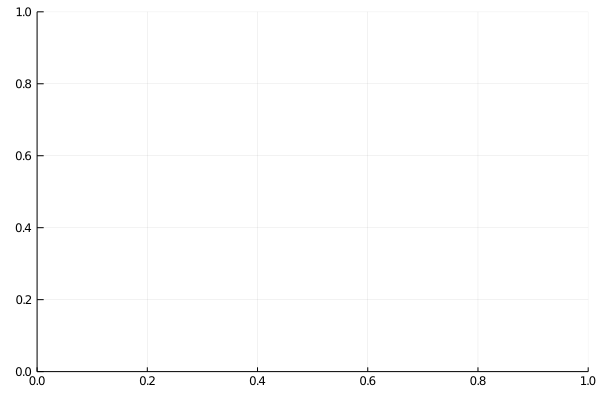

In [2]:
using Plots
p=plot()

In [32]:
x=[i for i=1:100]

100-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100

In [34]:
x2=x[1:10:100]

10-element Array{Int64,1}:
  1
 11
 21
 31
 41
 51
 61
 71
 81
 91

In [47]:
maximum(x2)

91

In [1]:
function makeCircleVals(r,center=[0,0])
    xOffset=center[1]
    yOffset=center[2]
    xVals=[r*cos(i)+xOffset for i=0:(pi/64):(2*pi)]
    yVals=[r*sin(i)+yOffset for i=0:(pi/64):(2*pi)]
    return xVals,yVals
end

makeCircleVals (generic function with 2 methods)

In [2]:
xVals,yVals=makeCircleVals(1)

([1.0, 0.9987954562051724, 0.9951847266721969, 0.989176509964781, 0.9807852804032304, 0.970031253194544, 0.9569403357322088, 0.9415440651830208, 0.9238795325112867, 0.9039892931234433  …  0.9039892931234431, 0.9238795325112865, 0.9415440651830208, 0.9569403357322088, 0.970031253194544, 0.9807852804032303, 0.9891765099647809, 0.9951847266721969, 0.9987954562051724, 1.0], [0.0, 0.049067674327418015, 0.0980171403295606, 0.14673047445536175, 0.19509032201612825, 0.24298017990326387, 0.29028467725446233, 0.33688985339222005, 0.3826834323650898, 0.4275550934302821  …  -0.42755509343028253, -0.3826834323650904, -0.33688985339222, -0.2902846772544625, -0.24298017990326418, -0.19509032201612872, -0.1467304744553624, -0.0980171403295605, -0.04906767432741809, -2.4492935982947064e-16])

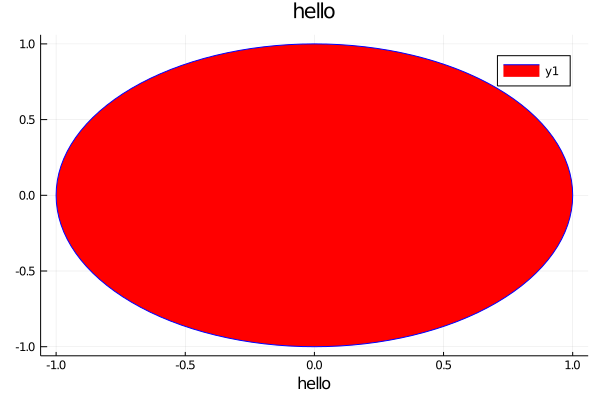

In [26]:
using Plots, Plots.PlotMeasures
plot(xVals,yVals,linecolor=:blue,fill=true,fillcolor=:red)
plot!(xlabel="hello",title="hello",top_margin=2mm)

In [5]:
try
    global x,y=1,1
catch
    global x,y=2,2
end


11


In [41]:
x=[]
for j=1:5
    if j==1
        for i=1:5
            xData=[i for i=1:10]
            yData=[i for i=1:10]
            push!(x,[xData,yData])
        end
    else
        for i=1:5
            xData=[i for i=1:10]
            yData=[i for i=1:10]
            x[i][1]=vcat(x[i][1],xData)
            x[i][2]=vcat(x[i][2],yData)
        end
    end
end

In [42]:
x[1]

2-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [72]:
function getLims(xList,yList,padding,maxFrame,oldCenter) #determines plot limits at each frame, padding in units of pos
    xMin=minimum(xList) #where xList contains the current x position of all bodies
    xMax=maximum(xList) #ditto but max
    dx=xMax-xMin
    yMin=minimum(yList) #same as above but for y
    yMax=maximum(yList)
    dy=yMax-yMin
    println("dx = $dx; dy = $dy")
    horizontalExtraRatio=1920/1080 #landscape picture has extra space in x direction
    centerX,centerY=(xMax+xMin)/2,(yMax+yMin)/2
    if dx>=dy && dx<maxFrame
        #use x for square
        println("used x calc")
        xlims=[xMin-padding,xMin+dx*horizontalExtraRatio+padding]
        ylims=[yMin-padding,yMin+dx+padding]
    elseif dy>dx &&dy<maxFrame
        #use y for square
        println("used y calc")
        xlims=[xMin-padding,xMin+dy*horizontalExtraRatio+padding]
        ylims=[yMin-padding,yMax+padding]
    else #somebody has been ejected
        xForCenter=[]
        yForCenter=[]
        for i=1:length(xList)
            for j=(i+1):length(xList)
                dist=sqrt((xList[i]-xList[j])^2 + (yList[i]-yList[j])^2)
                if dist<maxFrame
                    push!(xForCenter,(xList[i]+xList[j])/2) #exclude far away things from calculation of "center"
                    push!(yForCenter,(yList[i]+yList[j])/2)
                end
            end
        end
        function getCenter(xForCenter,yForCenter,oldCenter)
            try
                centerX,centerY=sum(xForCenter)/length(xForCenter),sum(yForCenter)/length(yForCenter)
                println(centerX,centerY)
                return centerX,centerY
            catch
                centerX,centerY=oldCenter[1],oldCenter[2]
                return centerX,centerY
            end
        end
        centerX,centerY=getCenter(xForCenter,yForCenter,oldCenter)
        diffX,diffY=abs(centerX-oldCenter[1]),abs(centerY-oldCenter[2])
        maxShift=maxFrame/100 #only let the center move by 1/100th of a frame in either direction
        if diffX>maxShift
            centerX=centerX/abs(centerX)*maxShift #preserves direction but limits motion
        end
        if diffY>maxShift
            centerY=centerY/abs(centerY)*maxShift
        end
        xlims=[centerX-maxFrame/2*horizontalExtraRatio-padding,centerX+maxFrame/2*horizontalExtraRatio+padding]#keep padding to be consistent w/above
        ylims=[centerY-maxFrame/2-padding,centerY+maxFrame/2+padding]#even though it makes maxFrame not really max frame
    end
    return xlims,ylims,[centerX,centerY]
end

getLims (generic function with 1 method)

In [78]:
x=[1,2,3,4,200]
y=[0,0,0,0,0]

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

In [79]:
getLims(x,y,0,100,[0,0])

dx = 199; dy = 0
2.50.0


([-87.88888888888889, 89.88888888888889], [-50.0, 50.0], [1.0, 0.0])

In [80]:
x=[]
length(x)

0

In [86]:
test=[1,2,3,4]
min=minimum(test)
test=filter!(x->x!=min,test)

3-element Array{Int64,1}:
 2
 3
 4

In [87]:
test

3-element Array{Int64,1}:
 2
 3
 4

In [88]:
x=-5
sign(x)

-1